#### Considering additional chemicals beyond the centroids 

#### Reworking to consider whether there is a sweet spot for the number of additional substances

Created by: Grace Patlewicz<br>
Last modified: 06 November 2023<br>
Change: Additional background

In response to the question of whether there is a defined number of candidates to select which will cover a specific structural diversity. This notebook tries some exploratory work to uncover a means of using the MaxMin approach to derive a ranked list of diverse chemicals on a per terminal category basis from which a plot of number of diverse picks vs structural coverage % captured could be constructed.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import openpyxl
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

#Show mols in dataframes
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import HTML
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import os
from scipy.spatial.distance import pdist, squareform
import sys

In [2]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'

In [3]:
LIB = TOP+'src/models/'
if not LIB in sys.path: 
    sys.path.insert(0,LIB)

In [4]:
from model_functions import *

In [5]:
df = pd.read_excel(interim_dir+'final_universe_wMaxMin_061123.xlsx',  index_col = [0])

In [6]:
df.head()

,dtxsid,DSSTox_QC-Level,Substance_Name,Substance_CASRN,Substance_Type,smiles,Structure_InChI,Structure_InChIKey,Structure_Formula,Structure_MolWt,...,lvl_cluster_d,lvl3_centroid,lvl3_centroid2,lvl3_analogues,lvl3_Dist,final_centroid,final_dist,group,group_str,MaxMin_picks
0,DTXSID6071908,DSSTox_High,N-Ethyl-N-((pentadecafluoroheptyl)sulphonyl)gl...,68957-63-1,Single Compound,CCN(CC(O)=O)S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)...,"InChI=1S/C11H8F15NO4S/c1-2-27(3-4(28)29)32(30,...",IOQHTIQMCISFKB-UHFFFAOYSA-N,C11H8F15NO4S,535.22,...,NaN,NaN,NaN,NaN,NaN,DTXSID6071908,0.000000,"('FASA based PFAA precursors', 'gte7', nan, nan)","('FASA based PFAA precursors', 'gte7', nan, nan)",1
1,DTXSID8071358,DSSTox_High,N-Methyl-perfluoro-1-heptanesulfonamide,68259-14-3,Single Compound,CNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)...,"InChI=1S/C8H4F15NO2S/c1-24-27(25,26)8(22,23)6(...",KDHCALLFPWZTPN-UHFFFAOYSA-N,C8H4F15NO2S,463.16,...,NaN,NaN,NaN,NaN,NaN,DTXSID6071908,0.640000,"('FASA based PFAA precursors', 'gte7', nan, nan)","('FASA based PFAA precursors', 'gte7', nan, nan)",0
2,DTXSID1071907,DSSTox_High,N-Ethylpentadecafluoro-1-heptanesulfonamide,68957-62-0,Single Compound,CCNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,"InChI=1S/C9H6F15NO2S/c1-2-25-28(26,27)9(23,24)...",WMOMXEHEPXLIAV-UHFFFAOYSA-N,C9H6F15NO2S,477.19,...,NaN,NaN,NaN,NaN,NaN,DTXSID6071908,0.615385,"('FASA based PFAA precursors', 'gte7', nan, nan)","('FASA based PFAA precursors', 'gte7', nan, nan)",0
3,DTXSID001026645,DSSTox_Low,"1,1,2,2,3,3,4,4,5,5,6,6,7,7,7-Pentadecafluoro-...",167398-54-1,Single Compound,OCCNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...,"InChI=1S/C9H6F15NO3S/c10-3(11,4(12,13)6(16,17)...",LJJUSVBJKZXMCP-UHFFFAOYSA-N,C9H6F15NO3S,493.19,...,NaN,NaN,NaN,NaN,NaN,DTXSID6071908,0.660714,"('FASA based PFAA precursors', 'gte7', nan, nan)","('FASA based PFAA precursors', 'gte7', nan, nan)",0
4,DTXSID301026644,DSSTox_Low,(Perfluoroheptyl)(sulfonylamino)acetic acid,1003194-00-0,Single Compound,OC(=O)CNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...,"InChI=1S/C9H4F15NO4S/c10-3(11,4(12,13)6(16,17)...",LAAXCIZXZCKWFF-UHFFFAOYSA-N,C9H4F15NO4S,507.17,...,NaN,NaN,NaN,NaN,NaN,DTXSID6071908,0.592593,"('FASA based PFAA precursors', 'gte7', nan, nan)","('FASA based PFAA precursors', 'gte7', nan, nan)",0


In [7]:
df.columns

Index(['dtxsid', 'DSSTox_QC-Level', 'Substance_Name', 'Substance_CASRN',
       'Substance_Type', 'smiles', 'Structure_InChI', 'Structure_InChIKey',
       'Structure_Formula', 'Structure_MolWt', 'Structure_SMILES_2D-QSAR',
       'Canonical_QSARr', 'TSCA_STATUS', 'chain_length', 'category',
       'MolWeight', 'LogP_pred', 'LogP_predRange', 'AD_LogP', 'AD_index_LogP',
       'Conf_index_LogP', 'MP_pred', 'MP_predRange', 'AD_MP', 'AD_index_MP',
       'Conf_index_MP', 'BP_pred', 'BP_predRange', 'AD_BP', 'AD_index_BP',
       'Conf_index_BP', 'LogVP_pred', 'VP_predRange', 'AD_VP', 'AD_index_VP',
       'Conf_index_VP', 'LogWS_pred', 'WS_predRange', 'AD_WS', 'AD_index_WS',
       'Conf_index_WS', 'LogHL_pred', 'HL_predRange', 'AD_HL', 'AD_index_HL',
       'Conf_index_HL', 'ID', 'tsca_match', 'subcategory', 'cluster',
       'cluster_centroid', 'centroid_x', 'centroid2', 'centroid_y',
       'analogues', 'Dist', 'level2_cluster_centroid', 'cluster_d',
       'lvl2_centroid', 'lvl2_centro

In [8]:
df.final_centroid.nunique()

90

In [9]:
cats = df['group_str'].unique().tolist()

In [10]:
def content_max(df,  k = None):
    content = {}
    tdf = df[df['group_str'] == k]
    content['t_dict'] = {k:Chem.MolFromSmiles(v) for k,v in zip(tdf['dtxsid'], tdf['smiles'])}
    content['fp_dict'] = [AllChem.GetMorganFingerprintAsBitVect(i, 3, 1024) for i in content['t_dict'].values()]
    content['nfp_dict'] = len(content['fp_dict'])
    content['t_index'] = {k:v for k,v in enumerate(content['t_dict'].keys())} 
    content['dm'] = pd.DataFrame(squareform(pdist(pd.DataFrame(np.array(content['fp_dict']), index = content['t_dict'].keys()), 'jaccard')), index = content['t_dict'].keys(), columns = content['t_dict'].keys())
    content['k'] = k
    
    return content

In [11]:
lte_summaries = []
for k in cats:
    try:
        lte_summaries.append(content_max(df, k))
    except Exception as error:
        print(k)

[17:25:35] WARNING: not removing hydrogen atom without neighbors


In [12]:
from rdkit.SimDivFilters import MaxMinPicker

In [13]:
def picker_func(fps, n1, start_with  = 1, n2 = 3, label = None, fps_index = None):
    picker_dict = {}
    mmp = MaxMinPicker()
    picker_dict['label'] = label
    picker_dict['indices'] = mmp.LazyBitVectorPick(fps,n1, start_with+n2, [0])
    picker_dict['diverse_chems'] = [fps_index[x] for x in picker_dict['indices']]
    return picker_dict

In [14]:
picker_lst = []
for i in range(len(lte_summaries)):
    if lte_summaries[i]['nfp_dict'] > 5:
        picker_lst.append(picker_func(lte_summaries[i]['fp_dict'], n1 =lte_summaries[i]['nfp_dict'], n2 = lte_summaries[i]['nfp_dict']-1, label = lte_summaries[i]['k'], fps_index = lte_summaries[i]['t_index'],))


In [15]:
def representive(df, lst):
    temps = []
    for n in range(1,len(lst)):
        a = lst[:n]
        b = np.mean(np.min(df.loc[a], axis = 0))
        temps.append([n,b])
    new_df = pd.concat([pd.DataFrame(temps), np.cumsum(pd.DataFrame(temps)[1])], axis = 1)
    new_df.columns = ['#', 'min', 'cummin']
    new_df['norm_min'] = new_df['cummin']/np.sum(new_df['min'])
    return new_df

In [16]:
index_pick = {k: picker_lst[k]['label'] for k in range(len(picker_lst))}
rev_index_picks = {v:k for k,v in index_pick.items()}

In [17]:
def summary_exp(i = 0):
    summary = {}
    k = lte_summaries[i]['k']
    x = rev_index_picks[k]
    summary['label'] = lte_summaries[i]['k']
    summary['representative'] = representive(lte_summaries[i]['dm'],picker_lst[x]['diverse_chems'])
    summary['chk'] = summary['label'], x
    return summary

In [18]:
representive(lte_summaries[0]['dm'], picker_lst[0]['diverse_chems'])

,#,min,cummin,norm_min
0,1,0.478014,0.478014,0.110565
1,2,0.408458,0.886473,0.205042
2,3,0.381714,1.268187,0.293333
3,4,0.342090,1.610277,0.372459
4,5,0.331226,1.941503,0.449072
...,...,...,...,...
100,101,0.000000,4.323369,1.000000
101,102,0.000000,4.323369,1.000000
102,103,0.000000,4.323369,1.000000
103,104,0.000000,4.323369,1.000000


In [19]:
check_lst = []
for e in range(len(lte_summaries)):
    try:
        a = summary_exp(i=e)
    except Exception as error:
        print(e)
    finally:
        check_lst.append(a)

36
37
74
77


In [20]:
def how_many(df, threshold = 0.8):
    return df.loc[np.where(df['norm_min'] >threshold)[0][0], '#']

In [21]:
def threshold_3(df, threshold = 3):
    return df.loc[np.where(df['#'] == threshold)[0][0], 'norm_min']

In [22]:
number_chems = {}
for e in range(len(check_lst)):
    a = how_many(check_lst[e]['representative'], threshold = 0.8)
    b = check_lst[e]['label']
    c = np.round(threshold_3(check_lst[e]['representative'], threshold = 3)*100,2)
    d = check_lst[e]['representative'].shape[0]+1
    number_chems[b] =[a,c,d]

In [23]:
df2 = pd.concat([pd.DataFrame(list(number_chems.items())), pd.DataFrame(list(number_chems.items()))[1].apply(pd.Series)], axis=1)
df2.columns = ['terminal_category', 'temp', 'ideal#', '%diversity', 'category_size']
df2.drop(['temp'], axis = 1, inplace =True)

In [24]:
df2.sort_values('%diversity', ascending = False).to_csv(interim_dir+'category_diversity_unconstrained_061123.csv')

In [25]:
df2.sort_values('%diversity', ascending = False)

,terminal_category,ideal#,%diversity,category_size
75,"('unclassified', 'gte7', 3.0, 3.0)",1.0,100.00,9.0
35,"('PFAA precursors', 'lt7', 1.0, 1.0)",3.0,85.29,7.0
38,"('PFAA precursors', 'lt7', 3.0, 2.0)",3.0,84.41,12.0
50,"('PFAS derivatives', 'lt7', 4.0, 1.0)",3.0,84.32,6.0
76,"('unclassified', 'gte7', 3.0, 4.0)",4.0,75.47,13.0
...,...,...,...,...
29,"('Other aliphatics', 'lt7', 2.0, 4.0)",214.0,1.88,481.0
31,"('Other aliphatics', 'lt7', 3.0, 2.0)",308.0,1.43,779.0
64,"('Side-chain aromatics', 'lt7', 3.0, 2.0)",390.0,1.01,890.0
65,"('Side-chain aromatics', 'lt7', 3.0, 3.0)",766.0,0.57,1758.0


In [26]:
df2[df2['%diversity']>=50].sort_values('%diversity', ascending = False)

,terminal_category,ideal#,%diversity,category_size
75,"('unclassified', 'gte7', 3.0, 3.0)",1.0,100.00,9.0
35,"('PFAA precursors', 'lt7', 1.0, 1.0)",3.0,85.29,7.0
38,"('PFAA precursors', 'lt7', 3.0, 2.0)",3.0,84.41,12.0
50,"('PFAS derivatives', 'lt7', 4.0, 1.0)",3.0,84.32,6.0
76,"('unclassified', 'gte7', 3.0, 4.0)",4.0,75.47,13.0
47,"('PFAS derivatives', 'lt7', 2.0, 2.0)",4.0,68.31,8.0
34,"('PFAA precursors', 'gte7', nan, nan)",5.0,66.84,57.0
7,"('Fluorotelomer PFAA precursors', 'lt7', 3.0, ...",4.0,66.69,24.0
5,"('Fluorotelomer PFAA precursors', 'lt7', 2.0, ...",5.0,63.55,19.0
8,"('Fluorotelomer PFAA precursors', 'lt7', 3.0, ...",6.0,58.96,19.0


In [27]:
df2.describe()

,ideal#,%diversity,category_size
count,86.000000,86.000000,86.000000
mean,66.069767,25.228023,179.046512
std,156.267929,22.963802,376.309913
min,1.000000,0.380000,6.000000
25%,10.000000,8.277500,29.250000
50%,21.000000,18.405000,73.000000
75%,46.500000,35.300000,136.750000
max,1149.000000,100.000000,2733.000000


In [28]:
check_lst[0]

{'label': "('FASA based PFAA precursors', 'gte7', nan, nan)",
 'representative':        #       min    cummin  norm_min
 0      1  0.478014  0.478014  0.110565
 1      2  0.408458  0.886473  0.205042
 2      3  0.381714  1.268187  0.293333
 3      4  0.342090  1.610277  0.372459
 4      5  0.331226  1.941503  0.449072
 ..   ...       ...       ...       ...
 100  101  0.000000  4.323369  1.000000
 101  102  0.000000  4.323369  1.000000
 102  103  0.000000  4.323369  1.000000
 103  104  0.000000  4.323369  1.000000
 104  105  0.000000  4.323369  1.000000
 
 [105 rows x 4 columns],
 'chk': ("('FASA based PFAA precursors', 'gte7', nan, nan)", 0)}

In [29]:
def plot_rep(df, label = None):
    fig, ax = plt.subplots(figsize = (10,9))
    ax.set_xlabel('Number of chemicals')
    ax.set_ylabel('Cumulative minimum distance')
    ax.plot(df['#'],  df['norm_min'], linestyle = 'none', marker = '.', label = label)
    ax.legend(bbox_to_anchor=(1, 1))
    return fig, ax

(<Figure size 1000x900 with 1 Axes>,
 <Axes: xlabel='Number of chemicals', ylabel='Cumulative minimum distance'>)

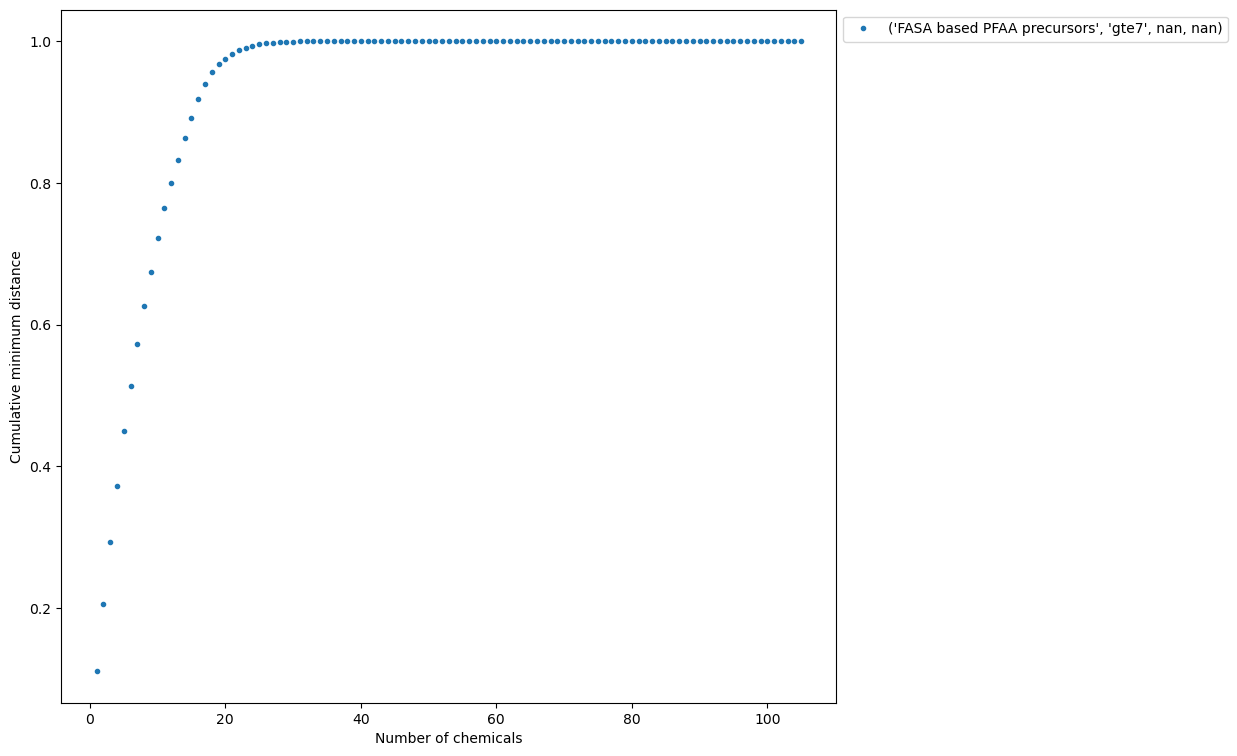

In [30]:
plot_rep(check_lst[0]['representative'], label = check_lst[0]['label'])

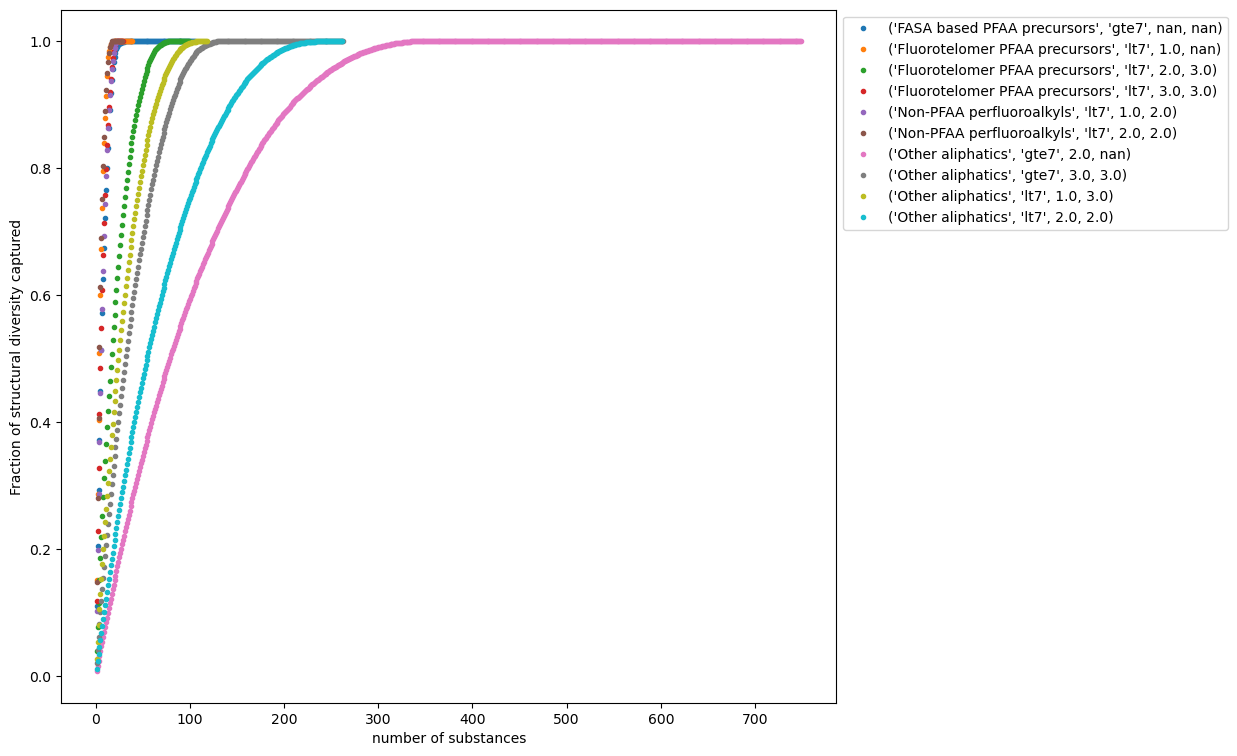

In [31]:
fig, ax = plt.subplots(figsize = (10,9))
for i in range(len(check_lst))[0:30:3]:
    ax.set_ylabel('Fraction of structural diversity captured')
    ax.set_xlabel('number of substances')
    #ax.set_title('ECDFs of within Category-Subcategory combinations')
    ax.plot(check_lst[i]['representative']['#'],check_lst[i]['representative']['norm_min'], marker = '.', linestyle = 'none', label = check_lst[i]['label'])
    ax.legend(bbox_to_anchor=(1, 1))
    #ax.annotate(" ", xy = (0.65,0.8), xytext = (0.5, 0.8), arrowprops = dict(arrowstyle = '->', lw = 2, color = 'black'))
fig.savefig(figures_dir+'Figure1_structural_diversity_061123.png', dpi = 300, bbox_inches='tight')

In [50]:

#check_lst[0]['representative']['norm_min']

In [51]:
mydf = []
for i in range(0,len(check_lst)):
    a = check_lst[i]['representative']
    a['category'] = check_lst[i]['label']
    mydf.append(a)


In [52]:
newdf = pd.concat(mydf)

In [53]:
newdf['pct_norm_min'] = round(100*newdf['norm_min'],2)

In [54]:
new_df = pd.pivot_table(newdf, index = 'category', values = 'pct_norm_min', columns = '#')

In [55]:
new_df2 = new_df.copy()
new_df2 = new_df2.replace(np.nan,100)
new_df2

#,1,2,3,4,5,6,7,8,9,10,...,2723,2724,2725,2726,2727,2728,2729,2730,2731,2732
category,,,,,,,,,,,,,,,,,,,,,
"('FASA based PFAA precursors', 'gte7', nan, nan)",11.06,20.50,29.33,37.25,44.91,51.35,57.22,62.57,67.48,72.18,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
"('FASA based PFAA precursors', 'lt7', nan, nan)",5.60,10.85,15.95,20.59,25.06,29.43,33.45,37.30,40.93,44.46,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
"('Fluorotelomer PFAA precursors', 'gte7', nan, nan)",6.63,12.80,18.44,23.77,28.91,33.62,38.18,42.43,46.53,50.57,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
"('Fluorotelomer PFAA precursors', 'lt7', 1.0, nan)",15.10,28.65,40.30,50.96,60.10,67.30,73.73,79.63,83.97,87.88,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
"('Fluorotelomer PFAA precursors', 'lt7', 2.0, 1.0)",12.88,23.45,32.05,39.81,46.84,53.26,59.30,64.51,69.24,73.68,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"('unclassified', 'lt7', 2.0, 3.0)",4.85,9.49,14.00,18.22,22.32,26.32,30.20,33.88,37.39,40.72,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
"('unclassified', 'lt7', 3.0, 1.0)",19.62,32.51,42.90,52.41,61.07,68.85,75.77,81.83,87.02,91.35,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
"('unclassified', 'lt7', 3.0, 2.0)",10.32,19.49,27.85,35.58,42.36,48.68,54.53,59.81,64.59,69.00,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


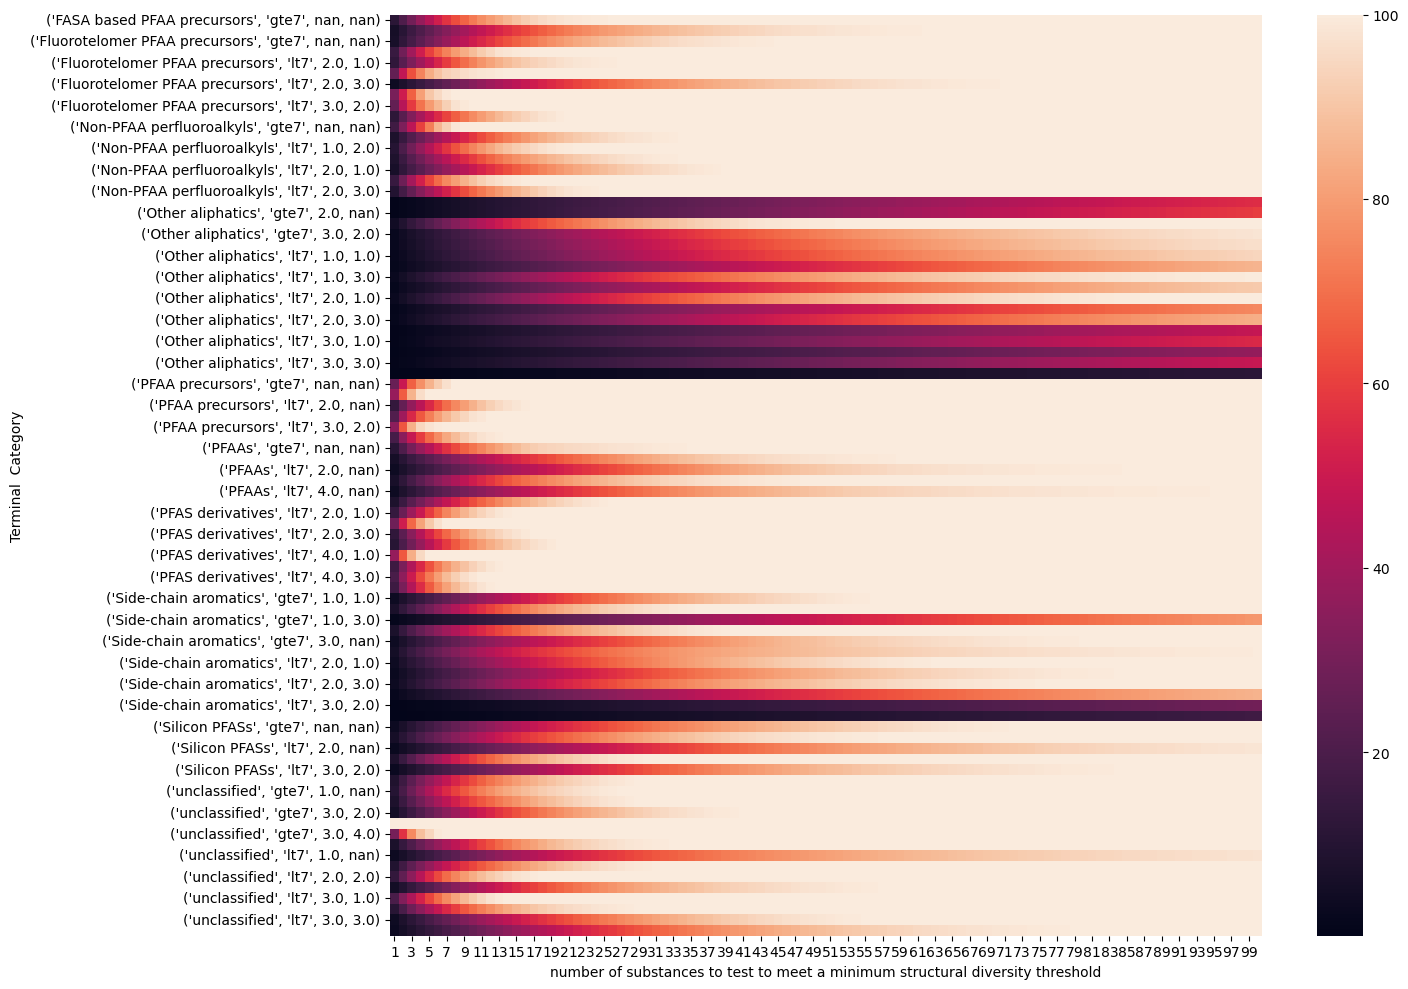

In [57]:
plt.figure(figsize = (15,10))
sns.heatmap(new_df2.iloc[:,:100])
plt.xlabel('number of substances to test to meet a minimum structural diversity threshold')
plt.ylabel('Terminal  Category')
plt.tight_layout()
plt.savefig(figures_dir+'structural_diversity_hm_261123.png', dpi = 300)

In [32]:
number_chems2 = []


for e in range(len(check_lst)):
    for i in np.arange(0.1,1,0.1):
        a = how_many(check_lst[e]['representative'], threshold = i)
        #print(a)
        b = check_lst[e]['label']
        number_chems2.append([a,b,i])

In [33]:
df3 = pd.DataFrame(number_chems2, columns = ['#ideal', 'terminal_category', 'threshold'])
df3

,#ideal,terminal_category,threshold
0,1,"('FASA based PFAA precursors', 'gte7', nan, nan)",0.1
1,2,"('FASA based PFAA precursors', 'gte7', nan, nan)",0.2
2,4,"('FASA based PFAA precursors', 'gte7', nan, nan)",0.3
3,5,"('FASA based PFAA precursors', 'gte7', nan, nan)",0.4
4,6,"('FASA based PFAA precursors', 'gte7', nan, nan)",0.5
...,...,...,...
805,22,"('unclassified', 'lt7', 3.0, 4.0)",0.5
806,27,"('unclassified', 'lt7', 3.0, 4.0)",0.6
807,34,"('unclassified', 'lt7', 3.0, 4.0)",0.7
808,42,"('unclassified', 'lt7', 3.0, 4.0)",0.8


In [34]:
df4 = pd.pivot_table(df3, index = 'terminal_category', values = '#ideal', columns = 'threshold')

In [35]:
df4.loc['other'] = list(np.repeat(5,9))

In [36]:
df5 = df4.sum(axis = 0).reset_index()

df5.columns = ['threshold', '#']

In [37]:
df5['threshold'] = (df5.threshold * 100)

<Figure size 1000x900 with 0 Axes>

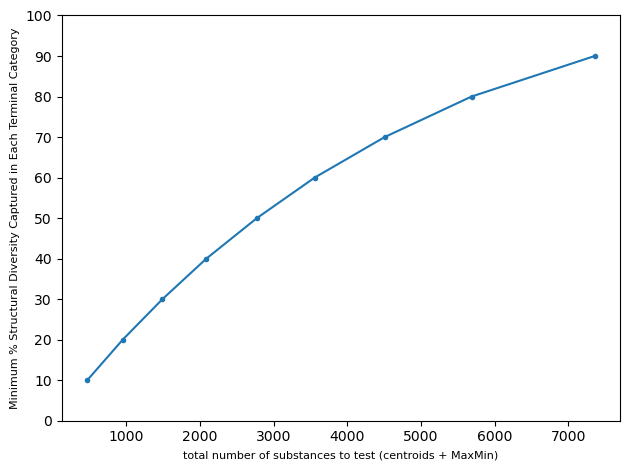

In [45]:
plt.figure(figsize = (10,9))
df5.plot(y = 'threshold', x = '#', marker = '.',legend = False)
#plt.ylim(0,150)
plt.ylim(0,100)
plt.yticks(np.arange(0, 100+10, 10.0))
plt.ylabel('Minimum % Structural Diversity Captured in Each Terminal Category', fontsize = 8)
plt.xlabel('total number of substances to test (centroids + MaxMin)', fontsize = 8)
plt.tight_layout()
plt.savefig(figures_dir+'Terminal_categorisation_unconstrained_landscape_261123.png', dpi = 300)